# Computational Social Science Project #2 

**Enter your Name:** Neena Albarus

**Group Members** Marisa Tsai, Sofia Guo, Reiley Reed

*Semester:* Fall 2023

Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv",
                       #CountyFips needs to be a string so leading 0 isn't dropped (this is only if you want to make choropleth map): 
                       dtype={"CountyFIPS": str}) 



# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
#diabetes = pd.read_csv(______,  dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
rows, columns = diabetes.shape

# Print the dimensions
print(f'Number of rows: {rows}')
print(f'Number of columns: {columns}')

Number of rows: 3220
Number of columns: 95


In [5]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [6]:
# identify non-numeric features

# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [7]:
#
# Now do the same as above, but for "Obesity_Number"
# identify non-numeric features

# Return rows where the column "Obesity_Number" is non-numeric and get the unique values of these rows the "~" below in front of obesity negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique())

['No Data']


In [8]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
# identify non-numeric features

# Return rows where the column "Physical_Inactivity_Number" is non-numeric and get the unique values of these rows the "~" below in front of Physical Inactivity negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique())



['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [9]:
# Recode variables

# Diabetes
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype('int64') 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype('int64') 

# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype('int64')

# Some final changes 
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype('float')

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [10]:
#Scale to county populations

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'sex and age_total population_sex ratio (males per 100 females)', 'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]

# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [11]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [12]:
#Check for duplicate columns
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_one race_1',
 'race_total population_two or more races_1',
 'hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population']

In [13]:
#
# drop columns from duplicates list

# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [14]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

/Users/ceto/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


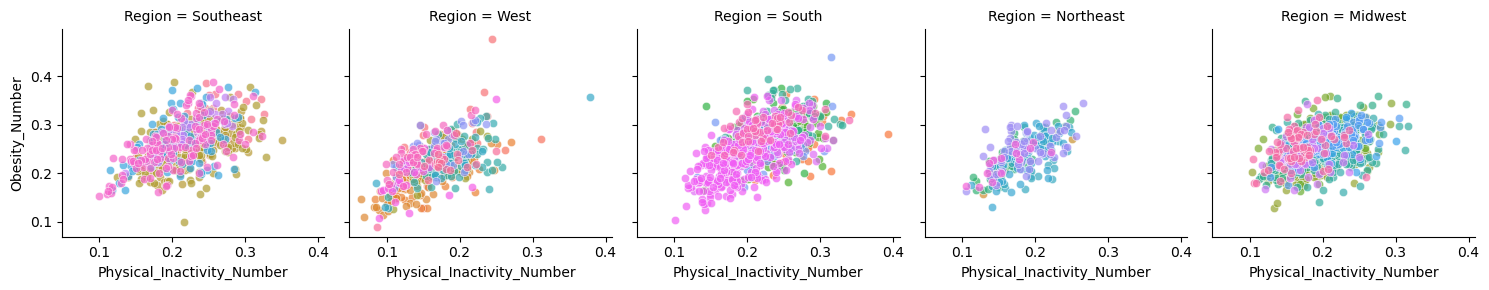

In [17]:
#
# EDA #1 and interpretations in this section 
#-----------

#plot the data
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "Physical_Inactivity_Number", "Obesity_Number", alpha=.7)

### Interpretations: overall diabetes by obesity

The prevalence of obesity and diabetes in different regions is highly relevant for understanding the risk factors, burden, and potential interventions related to diabetes in specific geographic areas. 

/Users/ceto/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


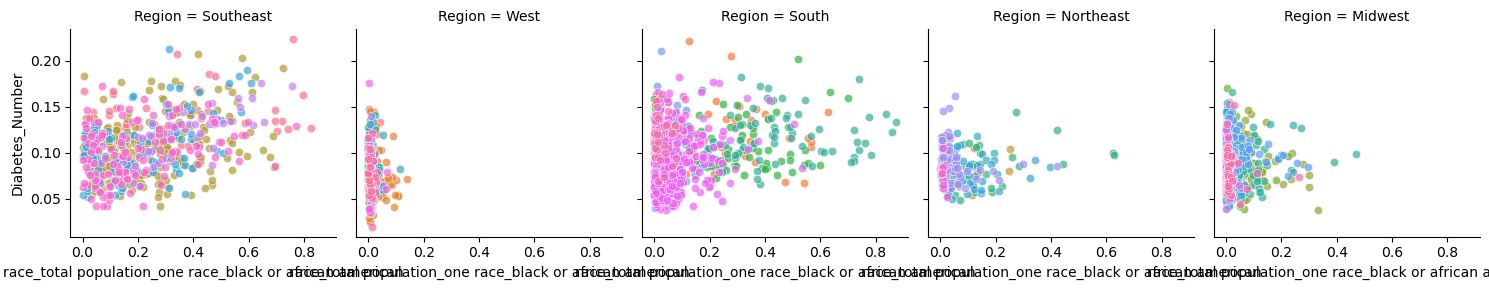

In [18]:
#
# EDA #2 and interpretations in this section 
# Create a FacetGrid with multiple scatter plots based on Region and State
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "race_total population_one race_black or african american", "Diabetes_Number", alpha=0.7)

### Interpretations: Black ppl

These allow for a nuanced analysis of regional disparities in diabetes prevalence among Black people. Researchers can pinpoint areas where Black communities may face a disproportionately higher burden of diabetes.

/Users/ceto/anaconda3/envs/CSS/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


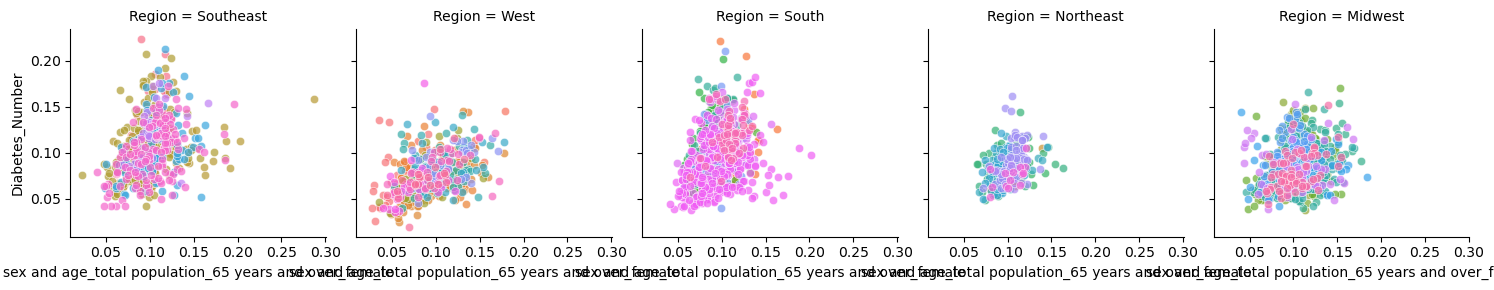

In [19]:
#
# EDA #3 and interpretations in this section 
#
# Create a FacetGrid with multiple scatter plots based on Region and State
g = sns.FacetGrid(diabetes, col="Region", hue="State")
g.map(sns.scatterplot, "sex and age_total population_65 years and over_female", "Diabetes_Number", alpha=0.7)

### Interpretations: elderly women 

By focusing on elderly women (represented by "65 years and over female") within specific regions, the graphs allow for a targeted analysis of diabetes in this group. This data is essential for identifying regions where elderly women may face a higher risk of diabetes and tailoring healthcare interventions.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [20]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [21]:
## Partition data

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number'], 
                axis = 1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [22]:
# Training/test split

# set the random seed
np.random.seed(10)

# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test


In [23]:
#Validation split


# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

In [24]:
# Standardization
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

In [25]:
diabetes.head(15)

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very high penalty (very low, like alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):**

1. Linear Regression: 
    - Logic and Assumptions:Linear regression assumes a linear relationship between the predictor variables and the outcome variable
    - Pros:It provides insights into the strength and direction of the relationships 
    - Cons:It may not capture complex, nonlinear relationships in the data
    - Choice: It provides a baseline model and can help establish a foundation for understanding the relationships. From scatterplots, there appears to be strong positive linear relationships between the variables.
    
2. LASSO: 
    - Logic and Assumptions: Lasso adds a penalty term that encourages feature selection by setting some feature coefficients to zero.
    - Pros: It helps prevent overfitting and can improve model generalisation
    - Cons: It may result in slight increase in bias
    - Choice: Regularisation may reduce overfitting
    
3. Ridge: 
    - Logic and Assumptions:
    - Pros: It helps prevent overfitting by reducing the impact of large coefficients.
    - Cons: Ridge does not set feature coefficients to exactly zero
    - Choice: Regularisation may reduce overfitting

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (Linear) 


In [26]:
#
# Model 1 training
#-----------
# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit( X_train, y_train )

In [27]:
# print model coefficients and intercept
print(lin_model.coef_)
print(lin_model.intercept_)

[-5.13926868e-08  8.07992837e-03  7.19874363e-03  3.24667026e-03
  3.32980329e-04 -4.91419639e-03  4.91419639e-03 -4.85856124e-02
  4.39378485e-02  1.61475798e-02  1.14905611e-03 -7.67725761e-05
  6.67962693e-04  1.32519638e-03  1.19733752e-02  8.04202210e-03
  1.08784891e-02  1.01147925e-02  6.45367112e-03  3.50742549e-03
  3.82300323e-03  7.97702603e-03 -9.30162973e-04 -1.02499904e-03
  1.55753831e-04 -7.16419391e-04 -4.57367214e-04  1.89424630e-03
 -2.97369383e-03 -8.56009240e-03 -2.31577153e-03 -5.65191275e-04
  2.82933399e-15  3.68670424e-03 -4.25769106e-02 -3.33785286e-02
 -3.09322363e-02 -3.97986118e-03 -1.31932349e-02  4.17504512e-03
  4.76537026e-03 -6.80282780e-04 -5.77817046e-05 -2.27691110e-04
 -4.17504512e-03  1.63245777e-02 -2.32271346e-02  3.03875594e-03
 -2.58063651e-02  4.70525410e-03  1.86392418e-04  2.81127133e-03
  2.12440526e-05  2.82743061e-03 -3.16861978e-04  1.43490967e-03
  2.38769604e-03 -3.87911420e-04  2.47614669e-03 -2.47614669e-03
 -5.20741688e-03 -2.36971

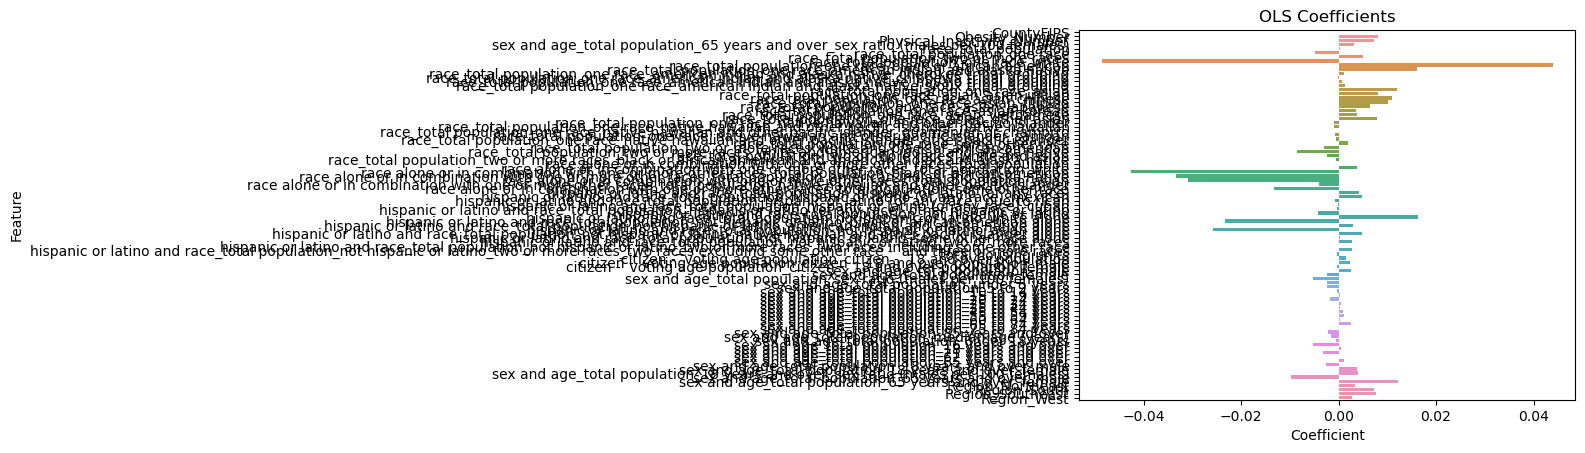

In [28]:
# create a dataframe with the coefficient and feature names for plotting
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot

#### Model 2:  (LASSO) 

In [29]:
#
# Model 2 training
#-----------
# create and fit the model
lasso_reg = Lasso(max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


#### Model 3:  (RIDGE) 

In [30]:
#
# Model 3 training
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did...


In [31]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

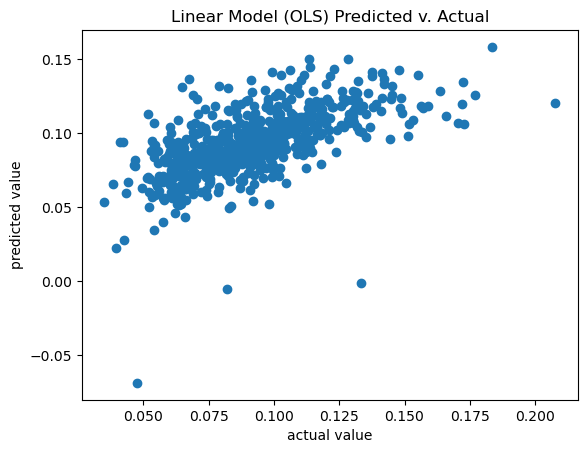

In [32]:
# using the validation dataset and the trained model, predict the number of riders 
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot

In [33]:
# calculate root mean squared errror
rmse(lin_pred,     # specify predicted values 
     y_validate)   # specify actual values values

0.02130238997666248

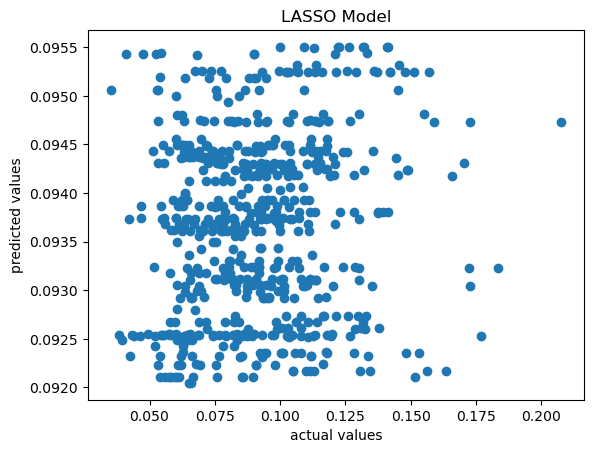

In [34]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [35]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

0.026013508613541243

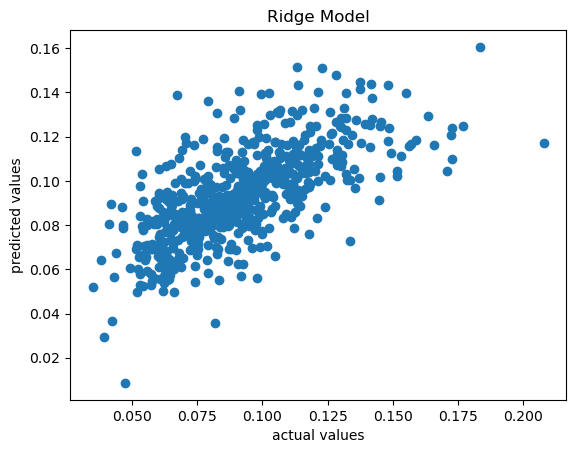

In [36]:
#
# Predict on validation data
#-----------
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()


In [37]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

0.019621248768207727

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [38]:
# Our best performing model is Ridge, so we will choose the top 50 out of 90 features that have
# the largest coefficients by absolute value

# take the absolute value of the ridge regression coefficients
ridge_reg_data['Coefficient'] = ridge_reg_data['Coefficient'].abs()

# select the top features with the largest coefficients by absolute magnitude
top_preds = ridge_reg_data[ridge_reg_data['Coefficient'] > 0.001].sort_values('Coefficient', ascending=False)

#extract the array of top predictor col names
names_top=top_preds['Feature'].values

In [39]:
# retrain the model using our selected features
# first filter X for the selected features from names_top
X=X[names_top]

In [40]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [41]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,                 # specify training dataset
                                                    y_train,                 # specify test dataset
                                                    train_size=0.75,      # specify proportional split for training
                                                    test_size=0.25)       # specify proportional split for test

In [42]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

In [43]:
#
# Model 3 retraining
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


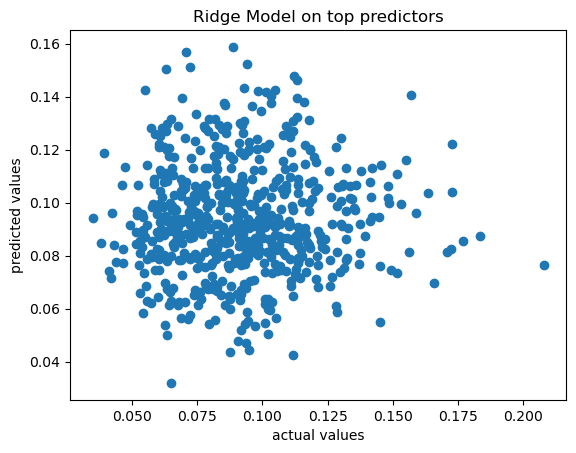

In [44]:
#
# Predict on test data
#-----------
# use the model to make predictions
ridge_pred = ridge_model.predict(X_test)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model on top predictors')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()


In [45]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_test)

0.02067293366045288

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [46]:
#
# Run cross-validation
#-----------

#
# RIDGE 
#-----------
# We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_test)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_test, y_test))
print('Validation RMSE', rmse(best_ridge_pred, y_test))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.5003221089908713
Validation R^2: 0.4364351986440064
Validation RMSE 0.020690335444414287


## 6. Discussion Questions

In this section, insert responses for discussion questions here.

In [47]:
scatterplot_data = diabetes[["Region", "State", "Diabetes_Number", "Obesity_Number"]]

# Display the data as a table
display(scatterplot_data)


,Region,State,Diabetes_Number,Obesity_Number
0,Southeast,Alabama,0.093804,0.244366
1,Southeast,Alabama,0.080281,0.233255
2,Southeast,Alabama,0.131875,0.310643
3,Southeast,Alabama,0.105251,0.290052
4,Southeast,Alabama,0.108977,0.246804
...,...,...,...,...
3215,West,Wyoming,0.058028,0.212208
3216,West,Wyoming,0.019038,0.088946
3217,West,Wyoming,0.069872,0.238973
3218,West,Wyoming,0.078361,0.213802


In [48]:
summary_stats1 = scatterplot_data[["Diabetes_Number", "Obesity_Number"]].describe()
summary_stats1

,Diabetes_Number,Obesity_Number
count,3112.000000,3112.000000
mean,0.092857,0.251666
std,0.028097,0.044323
min,0.019038,0.088946
25%,0.072169,0.223436
50%,0.089291,0.252390
75%,0.110175,0.280113
max,0.224208,0.476788


In [49]:
table_data = diabetes[["Region", "State", "sex and age_total population_65 years and over_female", "Diabetes_Number"]]

# Display the data as a table
display(table_data)

,Region,State,sex and age_total population_65 years and over_female,Diabetes_Number
0,Southeast,Alabama,0.082645,0.093804
1,Southeast,Alabama,0.104730,0.080281
2,Southeast,Alabama,0.102009,0.131875
3,Southeast,Alabama,0.090025,0.105251
4,Southeast,Alabama,0.098760,0.108977
...,...,...,...,...
3215,West,Wyoming,0.055738,0.058028
3216,West,Wyoming,0.069778,0.019038
3217,West,Wyoming,0.061332,0.069872
3218,West,Wyoming,0.109731,0.078361


In [50]:
# Select the columns of interest
columns_of_interest = ["sex and age_total population_65 years and over_female", "Diabetes_Number"]

# Calculate summary statistics
summary_stats2 = diabetes[columns_of_interest].describe()

# Display the summary statistics as a table
display(summary_stats2)

,sex and age_total population_65 years and over_female,Diabetes_Number
count,3112.000000,3112.000000
mean,0.099547,0.092857
std,0.023556,0.028097
min,0.022662,0.019038
25%,0.085041,0.072169
50%,0.098869,0.089291
75%,0.112504,0.110175
max,0.287374,0.224208


In [55]:
# Group the data by "State" and calculate summary statistics
summary_by_state2 = diabetes.groupby("State")[["Diabetes_Number", "sex and age_total population_65 years and over_female"]].describe()

# Display the summary statistics by state
display(summary_by_state2)


Diabetes_Number                                          \
                               count      mean       std       min       25%   
State                                                                          
Alabama                         67.0  0.127640  0.028785  0.077050  0.109014   
Alaska                          29.0  0.070556  0.030937  0.025494  0.049210   
Arizona                         15.0  0.090502  0.024164  0.056427  0.071863   
Arkansas                        74.0  0.112904  0.029272  0.066805  0.094427   
California                      58.0  0.074664  0.018678  0.044363  0.063753   
Colorado                        64.0  0.065205  0.023297  0.024672  0.048428   
Connecticut                      8.0  0.070043  0.010407  0.054019  0.063316   
Delaware                         3.0  0.096180  0.014155  0.079851  0.091790   
District of Columbia             1.0  0.064795       NaN  0.064795  0.064795   
Florida                         67.0  0.102635  0.022806  0.059900  0.088912   
Georgia                        155.0  0.109146  0.033983  0.042192  0.084683   
Hawaii                           4.0  0.082425  0.004326  0.078471  0.078803   
Idaho                           43.0  0.076055  0.019613  0.034355  0.066772   
Illinois                       102.0  0.083382  0.022506  0.037814  0.066284   
Indiana                         91.0  0.095831  0.023304  0.051432  0.078473   
Iowa                            97.0  0.079770  0.019867  0.044820  0.066796   
Kansas                         105.0  0.085986  0.021533  0.039192  0.072848   
Kentucky                       119.0  0.101191  0.023849  0.056524  0.084536   
Louisiana                       64.0  0.106157  0.027267  0.065469  0.086884   
Maine                           16.0  0.085265  0.014307  0.065063  0.076589   
Maryland                        24.0  0.092436  0.019831  0.056877  0.082711   
Massachusetts                   14.0  0.069850  0.012496  0.048554  0.063385   
Michigan                        83.0  0.094046  0.022490  0.054771  0.077025   
Minnesota                       86.0  0.077108  0.016042  0.039592  0.063964   
Mississippi                     80.0  0.118071  0.025948  0.066117  0.099655   
Missouri                       114.0  0.092270  0.024337  0.042112  0.076280   
Montana                         55.0  0.081645  0.018119  0.040266  0.068190   
Nebraska                        90.0  0.079458  0.014922  0.050139  0.068761   
Nevada                          17.0  0.084769  0.025528  0.051988  0.064285   
New Hampshire                   10.0  0.080657  0.015703  0.060605  0.071338   
New Jersey                      21.0  0.078019  0.017148  0.054616  0.066513   
New Mexico                      33.0  0.084569  0.023114  0.048544  0.068613   
New York                        62.0  0.086371  0.015239  0.049407  0.075834   
North Carolina                 100.0  0.106442  0.033693  0.051605  0.083892   
North Dakota                    52.0  0.080578  0.020051  0.042283  0.065618   
Ohio                            88.0  0.097487  0.019383  0.048747  0.085069   
Oklahoma                        77.0  0.098293  0.026745  0.040031  0.082351   
Oregon                          36.0  0.087954  0.019879  0.044854  0.071780   
Pennsylvania                    67.0  0.093513  0.020852  0.061319  0.079331   
Rhode Island                     5.0  0.072580  0.010738  0.060511  0.067537   
South Carolina                  46.0  0.120790  0.024717  0.066605  0.102958   
South Dakota                    62.0  0.084127  0.023691  0.039152  0.065875   
Tennessee                       95.0  0.109382  0.024190  0.056063  0.089108   
Texas                          253.0  0.085948  0.029185  0.037692  0.062750   
Utah                            29.0  0.064696  0.025672  0.035299  0.055002   
Vermont                         14.0  0.074518  0.013236  0.052076  0.063820   
Virginia                       131.0  0.098972  0.029445  0.041845  0.076351   
Washington           

In [51]:
table_race = diabetes[["Region", "State", "race_total population_one race_black or african american", "Diabetes_Number"]]

# Display the data as a table
display(table_race)


,Region,State,race_total population_one race_black or african american,Diabetes_Number
0,Southeast,Alabama,0.191395,0.093804
1,Southeast,Alabama,0.094970,0.080281
2,Southeast,Alabama,0.475758,0.131875
3,Southeast,Alabama,0.222755,0.105251
4,Southeast,Alabama,0.014954,0.108977
...,...,...,...,...
3215,West,Wyoming,0.008024,0.058028
3216,West,Wyoming,0.011883,0.019038
3217,West,Wyoming,0.000970,0.069872
3218,West,Wyoming,0.000123,0.078361


In [56]:
# Group the data by "State" and calculate summary statistics
summary_by_state3 = diabetes.groupby("State")[["Diabetes_Number", "race_total population_one race_black or african american", "Diabetes_Number" ]].describe()

# Display the summary statistics by state
display(summary_by_state3)


Diabetes_Number                                          \
                               count      mean       std       min       25%   
State                                                                          
Alabama                         67.0  0.127640  0.028785  0.077050  0.109014   
Alaska                          29.0  0.070556  0.030937  0.025494  0.049210   
Arizona                         15.0  0.090502  0.024164  0.056427  0.071863   
Arkansas                        74.0  0.112904  0.029272  0.066805  0.094427   
California                      58.0  0.074664  0.018678  0.044363  0.063753   
Colorado                        64.0  0.065205  0.023297  0.024672  0.048428   
Connecticut                      8.0  0.070043  0.010407  0.054019  0.063316   
Delaware                         3.0  0.096180  0.014155  0.079851  0.091790   
District of Columbia             1.0  0.064795       NaN  0.064795  0.064795   
Florida                         67.0  0.102635  0.022806  0.059900  0.088912   
Georgia                        155.0  0.109146  0.033983  0.042192  0.084683   
Hawaii                           4.0  0.082425  0.004326  0.078471  0.078803   
Idaho                           43.0  0.076055  0.019613  0.034355  0.066772   
Illinois                       102.0  0.083382  0.022506  0.037814  0.066284   
Indiana                         91.0  0.095831  0.023304  0.051432  0.078473   
Iowa                            97.0  0.079770  0.019867  0.044820  0.066796   
Kansas                         105.0  0.085986  0.021533  0.039192  0.072848   
Kentucky                       119.0  0.101191  0.023849  0.056524  0.084536   
Louisiana                       64.0  0.106157  0.027267  0.065469  0.086884   
Maine                           16.0  0.085265  0.014307  0.065063  0.076589   
Maryland                        24.0  0.092436  0.019831  0.056877  0.082711   
Massachusetts                   14.0  0.069850  0.012496  0.048554  0.063385   
Michigan                        83.0  0.094046  0.022490  0.054771  0.077025   
Minnesota                       86.0  0.077108  0.016042  0.039592  0.063964   
Mississippi                     80.0  0.118071  0.025948  0.066117  0.099655   
Missouri                       114.0  0.092270  0.024337  0.042112  0.076280   
Montana                         55.0  0.081645  0.018119  0.040266  0.068190   
Nebraska                        90.0  0.079458  0.014922  0.050139  0.068761   
Nevada                          17.0  0.084769  0.025528  0.051988  0.064285   
New Hampshire                   10.0  0.080657  0.015703  0.060605  0.071338   
New Jersey                      21.0  0.078019  0.017148  0.054616  0.066513   
New Mexico                      33.0  0.084569  0.023114  0.048544  0.068613   
New York                        62.0  0.086371  0.015239  0.049407  0.075834   
North Carolina                 100.0  0.106442  0.033693  0.051605  0.083892   
North Dakota                    52.0  0.080578  0.020051  0.042283  0.065618   
Ohio                            88.0  0.097487  0.019383  0.048747  0.085069   
Oklahoma                        77.0  0.098293  0.026745  0.040031  0.082351   
Oregon                          36.0  0.087954  0.019879  0.044854  0.071780   
Pennsylvania                    67.0  0.093513  0.020852  0.061319  0.079331   
Rhode Island                     5.0  0.072580  0.010738  0.060511  0.067537   
South Carolina                  46.0  0.120790  0.024717  0.066605  0.102958   
South Dakota                    62.0  0.084127  0.023691  0.039152  0.065875   
Tennessee                       95.0  0.109382  0.024190  0.056063  0.089108   
Texas                          253.0  0.085948  0.029185  0.037692  0.062750   
Utah                            29.0  0.064696  0.025672  0.035299  0.055002   
Vermont                         14.0  0.074518  0.013236  0.052076  0.063820   
Virginia                       131.0  0.098972  0.029445  0.041845  0.076351   
Washington           

In [52]:
# Calculate summary statistics for the selected columns
summary_stats3 = table_race.describe()

# Display the summary statistics as a table
display(summary_stats3)

,race_total population_one race_black or african american,Diabetes_Number
count,3112.000000,3112.000000
mean,0.090215,0.092857
std,0.144287,0.028097
min,0.000000,0.019038
25%,0.006815,0.072169
50%,0.022927,0.089291
75%,0.101805,0.110175
max,0.874123,0.224208


In [53]:
#using the model we selected to predict diabetes rates
X_reg = pd.concat([X_train, X_test, X_validate])
full_pred = ridge_grid_reg.best_estimator_.predict(X_reg)

#take top 10 percent to see which regions it is comprised of
topN = len(X_reg) // 10
top_idxs = full_pred.argsort()[-topN:]
X_reg.iloc[top_idxs].mean()[["Region_Southeast", "Region_South", "Region_Northeast", "Region_West"]]


Region_Southeast    0.524116
Region_South        0.434084
Region_Northeast    0.009646
Region_West         0.006431
dtype: float64

In [54]:
# Group the data by "State" and calculate summary statistics
summary_by_state = diabetes.groupby("State")["Diabetes_Number"].describe()

# Display the summary statistics by state
display(summary_by_state)


,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
Alabama,67.0,0.127640,0.028785,0.077050,0.109014,0.125672,0.141403,0.224208
Alaska,29.0,0.070556,0.030937,0.025494,0.049210,0.064622,0.081643,0.147746
Arizona,15.0,0.090502,0.024164,0.056427,0.071863,0.086513,0.106723,0.145355
Arkansas,74.0,0.112904,0.029272,0.066805,0.094427,0.111045,0.127981,0.222119
California,58.0,0.074664,0.018678,0.044363,0.063753,0.071058,0.082820,0.144069
Colorado,64.0,0.065205,0.023297,0.024672,0.048428,0.062444,0.077375,0.145104
Connecticut,8.0,0.070043,0.010407,0.054019,0.063316,0.071053,0.077593,0.084410
Delaware,3.0,0.096180,0.014155,0.079851,0.091790,0.103728,0.104344,0.104960
District of Columbia,1.0,0.064795,NaN,0.064795,0.064795,0.064795,0.064795,0.064795


1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one? 



**YOUR ANSWER HERE**...A model with high bias might make overly simplistic assumptions about the relationship between population information and diabetes rates, resulting in poor predictions on both the training data and new data.

A model with high variance might overfit the training data, capturing noise rather than true patterns. 

2. Define overfitting, and why it matters for machine learning. How can we address it?



**YOUR ANSWER HERE**...Overfitting occurs when the model fits the training data too closely, capturing not only the underlying patterns but also the noise or random fluctuations in the data. It can be addressed by getting more data, cross-validation, regularisation, ensemble methods, feature selection


3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**...

Among the regions, the Southeast and South regions stand out with strong positive associations, indicating that these regions are more likely to exhibit the predicted outcome compared to other regions. In contrast, the Northeast and West regions exhibit weaker positive associations, suggesting a less diabetes reported. Given the strong positive associations observed in the Southeast and South regions, it is advisable to prioritise these areas for intervention. Furthermore, states like Alabama, West Virginia, South Carolina and Mississippi have higher mean diabetes rates compared to the national average.

When considering elderly women, South Carolina stands out with the highest diabetes prevalence with an average rate of 12.08%. This rate is notably higher compared to many other states, indicating a significant public health concern. West Virginia is second highest with diabetes prevalence of 11.95%. When examining the Black population in the US, states in the southern part of the United States, including Alabama (12.7%), West Virginia (11.9%), and South Carolina (12.1%), consistently showed higher-than-average diabetes rates. These findings align with the broader trends indicating a higher prevalence of health risk factors in the South.

While the insights provided by the model are valuable, deploying it in a real-world application should be done cautiously. I would not be very confident without doing a more robust analysis of demographics by counties. 